In [1]:
from math import ceil, inf, isnan, sqrt 
from random import choice, random, seed

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from run_mskmeans import minsize_kmeans
from variance import compute_variance, count_mi_ni, equivalent_panel_size, get_layout, successive_stratification

Academic license - for non-commercial use only


In [2]:
seed(0)
np.random.seed(0)

In [3]:
sns.set(font_scale=1.35, rc={'text.usetex' : True})
sns.set_style("whitegrid")
purple = "#6A1B9A"; blue="#3F51B5"; green="#43A047"; orange="#FF9800"; red="#d32f2f"
sns.set_palette(sns.color_palette([blue, green, orange, red, purple]))

In [4]:
years = [2014, 2016]

We require that the GSS stata files from 2014 and 2016 (cross-section only) exist in the working directory. As of January 2018, zipped versions of these files are available at http://gss.norc.org/documents/stata/2014_stata.zip and http://gss.norc.org/Documents/stata/2016_stata.zip. The sha hashes of the files are as follows:

    SHA256(GSS2014.DTA) = 9a75a0dac39ff06a98855469603d9530a3fdc01cbb7c6c5cfb6154a1bc6194a5
    SHA256(GSS2016.DTA) = 9d4b02be154caaa25fe90e6bed96e9c837568854093d226a30e3739ef449d2dd

In [5]:
full_data14 = pd.read_stata("GSS2014.dta", index_col="id", convert_categoricals=False)
full_data16 = pd.read_stata("GSS2016.dta", index_col="id", convert_categoricals=False)

In 2014, restrict data to ballots A and C; in 2016 to ballots B and C. In both cases, the largest two ballots were chosen.

In [6]:
print({i: len(full_data14[full_data14["ballot"] == i]) for i in range(1, 4)})
print({i: len(full_data16[full_data16["ballot"] == i]) for i in range(1, 4)})
data14 = full_data14[full_data14["ballot"].isin([1, 3])]
data16 = full_data16[full_data16["ballot"].isin([2, 3])]
datas = {2014: data14, 2016: data16}
print({year: len(datas[year]) for year in years})

{1: 851, 2: 824, 3: 863}
{1: 911, 2: 977, 3: 979}
{2014: 1714, 2016: 1956}


We select a set of demographic features and check there are given by nearly all agents.

In [7]:
demographics = ["age", "sex", "race", "class", "degree", "region", "happy", "relig", "partyid", "childs", "marital", "vetyears", "srcbelt", "born"]

In [8]:
for year in years:
    print(f"Percentage of invalid answers by demographic feature in {year}:")
    for dem in demographics:
        print(f"{dem}: {100 * datas[year][dem].isna().sum() / len(datas[year]):.2f}%")

Percentage of invalid answers by demographic feature in 2014:
age: 0.47%
sex: 0.00%
race: 0.00%
class: 0.93%
degree: 0.00%
region: 0.00%
happy: 0.35%
relig: 0.70%
partyid: 1.40%
childs: 0.29%
marital: 0.23%
vetyears: 0.06%
srcbelt: 0.00%
born: 0.00%
Percentage of invalid answers by demographic feature in 2016:
age: 0.36%
sex: 0.00%
race: 0.00%
class: 0.77%
degree: 0.31%
region: 0.00%
happy: 0.36%
relig: 0.61%
partyid: 1.18%
childs: 0.36%
marital: 0.05%
vetyears: 0.20%
srcbelt: 0.00%
born: 0.15%


# Simple stratification

In [9]:
k = 50

In [10]:
min_sizes = {year: ceil(len(datas[year]) / k) for year in years}

In [11]:
uniform_stratification = {year: pd.DataFrame({"stratum": [0] * len(datas[year])}, index=datas[year].index) for year in years}

In [12]:
race_gender = {year: successive_stratification(datas[year], ["race", "sex"], min_sizes[year]) for year in years}

# Random stratification

In [13]:
non_demographics = {year: [att for att in datas[year].columns
                           if not att in demographics
                           and datas[year][att].isna().sum() <= 0.1 * len(datas[year])]
                    for year in years}

In [14]:
def random_m(year):
    category = choice(non_demographics[year])
    n = len(datas[year])
    random_agent = datas[year].sample().index[0]
    value = datas[year].loc[random_agent, category]
    if isnan(value):
        return random_m(year)
    if random() < .5:
        m = pd.DataFrame({"m": np.where(datas[year][category] <= value, 1, 0)}, index=datas[year].index)
    else:
        m = pd.DataFrame({"m": np.where(datas[year][category] >= value, 1, 0)}, index=datas[year].index)
    if len(set(m["m"])) < 2:
        return random_m(year)
    return m

In [15]:
def random_demographic_stratification(year, k):
    features = np.random.permutation(demographics)
    return successive_stratification(datas[year], features, ceil(len(datas[year]) / k))

In [16]:
simple = "$\\frac{n - 1}{n - k} \\, \\mathit{Var}(U_M) - \\frac{k}{n} \\sum_i \\frac{\\epsilon_i^2}{n_i}$"
def simple_bound(data, hidden_feature, strata, k):
    combination = data.join(strata, how="inner")
    n = len(data)
    m = len(data[data[hidden_feature] == 1])
    mi, ni = count_mi_ni(combination[hidden_feature], combination["stratum"])
    ell = len(ni)
    return k * m/n * (1 - m/n) - k/n * sum((mi[i] - m / n * ni[i])**2 / ni[i] for i in range(ell))

def simple_fraction(data, hidden_feature, strata, k):
    combination = data.join(strata, how="inner")
    n = len(data)
    m = len(data[data[hidden_feature] == 1])
    mi, ni = count_mi_ni(combination[hidden_feature], combination["stratum"])
    ell = len(ni)
    return (k/n * sum((mi[i] - m / n * ni[i])**2 / ni[i] for i in range(ell))) / (k * m/n * (1 - m/n))

In [17]:
samples = []
def sample_random(year, k):
    datum = {"year": year, "k": k}
    m = random_m(year)
    datum["$|M|$"] = len(m[m["m"] == 1])
    random_strat = random_demographic_stratification(year, k)
    datum["$\\ell$"] = len(set(random_strat["stratum"]))
    datum["$\\mathit{Var}(X_M)$"] = compute_variance(m, "m", random_strat, k)
    n = len(datas[year])
    datum["equivalent panel size"] = equivalent_panel_size(datum["$\mathit{Var}(X_M)$"], n, datum["$|M|$"], k)
    samples.append(datum)
    return datum

In [18]:
for year in years:
    for _ in range(250):
        sample_random(year, k)

In [19]:
d = pd.DataFrame(samples)

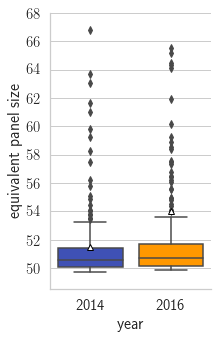

In [20]:
g = sns.catplot(data=d, x="year", y="equivalent panel size", kind="box", aspect=.7, showmeans=True,
                meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, palette=(blue, orange), saturation=1.)
g.ax.set_ylim((48.5, 68))
g.ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=2.0))
g.savefig("random_equivalent.pdf")

Outliers not shown in the figure:

In [21]:
d[(d["equivalent panel size"] < 48.5) | (d["equivalent panel size"] > 68)]

,$\ell$,$\mathit{Var}(X_M)$,$|M|$,equivalent panel size,k,year
115,37,7.975022,654,70.951743,50,2014
176,37,7.511003,558,70.132903,50,2014
245,38,7.939166,961,74.247657,50,2014
280,36,7.089586,1089,83.356004,50,2016
446,34,2.360576,816,227.648434,50,2016
498,36,1.028263,799,451.952795,50,2016


Compute the mean equivalent panel size for both years and the mean excluding all outliers above 68:

In [22]:
print({year: d[d["year"] == year]["equivalent panel size"].mean() for year in years})
print({year: d[(d["year"] == year) & (d["equivalent panel size"] <= 68)]["equivalent panel size"].mean() for year in years})

{2014: 51.463547776641775, 2016: 54.0460034768623}
{2014: 51.21682040919089, 2016: 51.61353699079559}


In [23]:
pd.DataFrame(samples)["equivalent panel size"].min()

49.74485118628462

# Case Study

Now, we select 10 attitude features per year, and a conditional to make them binary.

In [24]:
assert data14 is datas[2014] and data16 is datas[2016]
attitude14 = [("abdefect", data14["abdefect"] == 2),
              ("colcom", data14["colcom"] == 5),
              ("discaff", data14["discaff"].isin([1, 2])),
              ("getahead", data14["getahead"].isin([2, 3])),
              ("gunlaw", data14["gunlaw"] == 1),
              ("homosex", data14["homosex"].isin([1,2,3])),
              ("libmslm", data14["libmslm"] == 2),
              ("racopen", data14["racopen"] == 2),
              ("cappun", data14["cappun"] == 2),
              ("tax", data14["tax"] == 1)]
attitude16 = [("eqwlth", data16["eqwlth"].isin([1, 2, 3, 4])),
              ("helpful", data16["helpful"] == 1),
              ("helpsick", data16["helpsick"].isin([3, 4, 5])),
              ("polhitok", data16["polhitok"] == 2),
              ("pornlaw", data16["pornlaw"] == 1),
              ("conmedic", data16["conmedic"] == 2),
              ("contv", data16["contv"].isin([1, 2])),
              ("conarmy", data16["conarmy"].isin([2, 3])),
              ("natpark", data16["natpark"] == 1),
              ("helpblk", data16["helpblk"].isin([1, 2]))]
assert len(attitude14) == 10
assert len(attitude16) == 10
attitudes = {2014: attitude14, 2016: attitude16}

Check that all chosen attitude features are given for a large majority of agents (more than 90%):

In [25]:
for year in years:
    print(f"Percentage of invalid answers by attitude in {year}:")
    for att, _ in attitudes[year]:
        print(f"{att}: {100 * datas[year][att].isna().sum() / len(datas[year]):.2f}%")

Percentage of invalid answers by attitude in 2014:
abdefect: 4.73%
colcom: 5.19%
discaff: 3.33%
getahead: 0.82%
gunlaw: 1.23%
homosex: 3.68%
libmslm: 1.46%
racopen: 0.53%
cappun: 6.65%
tax: 2.63%
Percentage of invalid answers by attitude in 2016:
eqwlth: 1.02%
helpful: 0.51%
helpsick: 3.07%
polhitok: 4.09%
pornlaw: 0.92%
conmedic: 0.72%
contv: 0.92%
conarmy: 0.97%
natpark: 1.38%
helpblk: 4.14%


Attitude features were chosen to cover a wide range of political areas and issues, and should not be directly related. We check that this was successful, i.e. that none of the features have extremely positive or negative correlation. We find fairly high (anti-)correlations between features relating to social liberalism in the 2014 dataset (homosexuality, free speech, abortions), but none of them are unreasonably high. In the 2016 dataset, there is high correlation between attitudes relating to healthcare, affirmative action, and reducing income inequality.

In [26]:
for year in years:
    correlations = []
    data = datas[year]
    for att, m in attitudes[year]:
        for att2, m2 in attitudes[year]:
            if att >= att2:
                continue
            p1 = len(data[m]) / len(data)
            p2 = len(data[m2]) / len(data)
            var = len(data[m & m2]) / len(data) - p1 * p2
            corr = var / sqrt(p1 * (1 - p1)) / sqrt(p2 * (1 - p2))
            correlations.append((corr, (att, att2)))
    correlations.sort()
    print(f"10 highest correlations between attitude features in {year}:")
    for corr, (att, att2) in reversed(correlations[-10:]):
        print(f"{att} & {att2}: {100 * corr:.2f}%")
    print(f"10 lowest correlations between attitude features in {year}:")
    for corr, (att, att2) in correlations[:10]:
        print(f"{att} & {att2}: {100 * corr:.2f}%")

10 highest correlations between attitude features in 2014:
colcom & libmslm: 37.05%
abdefect & homosex: 25.68%
getahead & libmslm: 11.67%
cappun & racopen: 10.86%
cappun & gunlaw: 10.24%
gunlaw & racopen: 9.29%
discaff & homosex: 9.18%
cappun & libmslm: 8.71%
discaff & tax: 8.68%
homosex & tax: 8.23%
10 lowest correlations between attitude features in 2014:
homosex & libmslm: -24.00%
colcom & homosex: -17.22%
abdefect & libmslm: -15.13%
cappun & discaff: -11.33%
libmslm & tax: -11.16%
gunlaw & tax: -10.58%
homosex & racopen: -10.48%
discaff & libmslm: -9.75%
cappun & tax: -9.18%
racopen & tax: -8.82%
10 highest correlations between attitude features in 2016:
eqwlth & helpblk: 21.44%
helpblk & polhitok: 12.29%
eqwlth & polhitok: 11.87%
helpblk & natpark: 11.85%
conarmy & helpblk: 11.84%
eqwlth & natpark: 11.31%
conarmy & conmedic: 9.88%
conmedic & pornlaw: 8.89%
conarmy & eqwlth: 8.12%
helpsick & pornlaw: 7.90%
10 lowest correlations between attitude features in 2016:
helpblk & helpsick

Create new columns for the binary attitude features.

In [27]:
for year in years:
    datas[year] = datas[year].assign(**{att + "_bin": np.where(m, 1, 0) for att, m in attitudes[year]})

In [28]:
revealed_indices14 = [4, 7, 3, 1, 6]  # first 5 numbers of https://www.random.org/sequences/?min=0&max=9&col=1&format=html&rnd=new
revealed_indices16 = [3, 6, 5, 9, 4]
rev_att14 = [attitudes[2014][i] for i in revealed_indices14]
print("revealed attitudes 2014:", [att[0] for att in rev_att14])
rev_att16 = [attitudes[2016][i] for i in revealed_indices16]
print("revealed attitudes 2016:", [att[0] for att in rev_att16])
rev_atts = {2014: rev_att14, 2016: rev_att16}

nonrev_att14 = [attitudes[2014][i] for i in range(10) if i not in revealed_indices14]
print("non-revealed attitudes 2014:", [att[0] for att in nonrev_att14])
nonrev_att16 = [attitudes[2016][i] for i in range(10) if i not in revealed_indices16]
print("non-revealed attitudes 2016:", [att[0] for att in nonrev_att16])
nonrev_atts = {2014: nonrev_att14, 2016: nonrev_att16}

revealed attitudes 2014: ['gunlaw', 'racopen', 'getahead', 'colcom', 'libmslm']
revealed attitudes 2016: ['polhitok', 'contv', 'conmedic', 'helpblk', 'pornlaw']
non-revealed attitudes 2014: ['abdefect', 'discaff', 'homosex', 'cappun', 'tax']
non-revealed attitudes 2016: ['eqwlth', 'helpful', 'helpsick', 'conarmy', 'natpark']


In [29]:
categories = {year: demographics + [att + "_bin" for att, _ in rev_atts[year]] for year in years}
exports = {year: datas[year][categories[year]] for year in years}

We now export the data given to Experimenter B. The two files should hash as follows:

    SHA256(./data14.csv) = ff8e577c452e178bf9aece09cff06f4e99280a53f146e56ee3ff0c942d8b9817
    SHA256(./data16.csv) = 733ea9cfcfe2b0807bfd89e9a8d221763ed874040ffc2eaa2c81918b8e1ffe20

In [30]:
exports[2014].to_csv("data14.csv")
exports[2016].to_csv("data16.csv")

In [31]:
reveal_category14 = nonrev_atts[2014][4]  # index from https://www.random.org/integers/?num=1&min=0&max=4&col=5&base=10&format=html&rnd=new
reveal_category16 = nonrev_atts[2016][2]
print(reveal_category14[0], reveal_category16[0])

tax helpsick


# Manual Stratification

Read in the manual stratifications created by experimenter B. First, the stratification for both years without further information; then, the stratifications for which the category description (`tax` and `helpsick`, respectively) has been revealed.

In [32]:
manual14 = pd.read_csv("manual14.txt", header=None, names=["stratum"], delim_whitespace=True)
manual16 = pd.read_csv("manual16.txt", header=None, names=["stratum"], delim_whitespace=True)
manuals = {2014: manual14, 2016: manual16}

In [33]:
manual_tax = pd.read_csv("manual14_tax.txt", header=None, names=["stratum"], delim_whitespace=True)
manual_helpsick = pd.read_csv("manual16_helpsick.txt", header=None, names=["stratum"], delim_whitespace=True)

# Clustering

In [34]:
is_multidimensional = {
    "age": False,
    "sex": False,
    "race": True,
    "class": False,
    "degree": False,
    "region": True,
    "happy": False,
    "relig": True,
    "partyid": False, # map 7 to middle
    "childs": False,
    "marital": True,
    "vetyears": False, # map 4 to middle
    "srcbelt": False,
    "born": False
}
for year in years:
    for att, _ in rev_atts[year]:
        is_multidimensional[att + "_bin"] = False

Two demographic categories, `partyid` and `vetyears`, are essentially one-dimensional. However, their highest value does not correspond to an extreme on the spectrum. For example, consider the codes for `partyid`:

    partyid: Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?
    0: strong democrat
    1: not very strong democrat
    2: independent, close to democrat
    3: independent (neither, no response)
    4: independent, close to republican
    5: not very strong republican
    6: strong republican
    7: other party, refused to say

We remap value 7 to a neutral position, such that the remaining values constitute a one-dimensional spectrum:

In [35]:
rescaled = {}
for year in years:
    rescaled[year] = exports[year].copy()
    rescaled[year]["partyid"] = rescaled[year]["partyid"].replace(7, float("nan"))
    rescaled[year]["vetyears"] = rescaled[year]["vetyears"].replace(4, float("nan"))

In [36]:
for year in years:
    for att in categories[year]:
        if is_multidimensional[att]:
            vals = set(rescaled[year][att].dropna())
            rescaled[year] = rescaled[year].assign(**{att + str(int(v)): np.where(rescaled[year][att] == v, 1., 0.) for v in vals})
            del rescaled[year][att]
        else:
            mini = rescaled[year][att].min()
            maxi = rescaled[year][att].max()
            assert mini < maxi
            rescaled[year][att] = rescaled[year][att].map(lambda v: 0.5 if isnan(v) else (v - mini) / (maxi - mini))

In [37]:
for year in years:
    for att in rescaled[year].columns:
        assert sum(rescaled[year][att].isna()) == 0

In [38]:
clusterdatas = {}
kmeans = {}
for year in years:
    clusterdatas[year] = [tuple(row[1]) for row in rescaled[year].iterrows()]
    stratum, _ = minsize_kmeans(clusterdatas[year], len(datas[year]) // min_sizes[year], min_sizes[year])
    kmeans[year] = pd.DataFrame({"stratum": stratum}, index=rescaled[year].index)

# Evaluation

In [39]:
candidates = {"uniform": uniform_stratification, "gender/race": race_gender, "k-means": kmeans, "manual": manuals}
variances = []
for year in years:
    for att, _ in nonrev_atts[year]:
        m = len(datas[year][datas[year][att + "_bin"] == 1])
        for kind, strat_dict in candidates.items():
            expvar = compute_variance(datas[year], att + "_bin", strat_dict[year], k, "expvar")
            varexp = compute_variance(datas[year], att + "_bin", strat_dict[year], k, "varexp")
            equivalent_k = equivalent_panel_size(expvar + varexp, len(datas[year]), m, k)
            equivalent_k_norounding = equivalent_panel_size(expvar, len(datas[year]), m, k)
            simple = simple_fraction(datas[year], att + "_bin", strat_dict[year], k)
            variances.append({"year": year, "attitude": att, "stratification": kind, "variance": expvar + varexp, "varexp": varexp,
                              "expvar": expvar, "equivalent panel size": equivalent_k,
                              "equiv. panel size without rounding": equivalent_k_norounding,
                              "$\\frac{k}{n} \\sum_{i} \\frac{\\epsilon_i^2}{n_i} / \\left(k \\, \\frac{m}{n} \\, (1 - \\frac{m}{n})\\right)$": simple})
            

In [40]:
d = pd.DataFrame(variances)

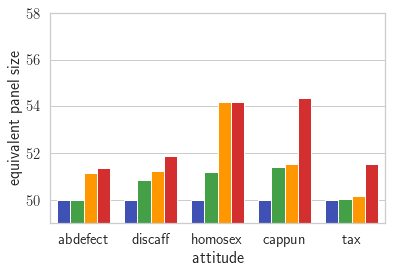

In [41]:
g = sns.barplot(data=d[d["year"] == 2014], x="attitude", y="equivalent panel size", hue="stratification", saturation=1.)
g.legend_.remove()
g.set_ylim((49, 58))
plt.gcf().subplots_adjust(bottom=0.15)
g.figure.savefig("compare_stratification14.pdf")

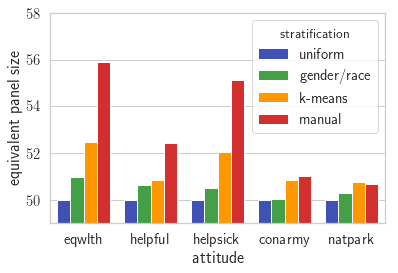

In [42]:
g = sns.barplot(data=d[d["year"] == 2016], x="attitude", y="equivalent panel size", hue="stratification", saturation=1.)
g.set_ylim((49, 58))
plt.gcf().subplots_adjust(bottom=0.15)
#plt.legend(loc="upper right")
#plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
g.figure.savefig("compare_stratification16.pdf")

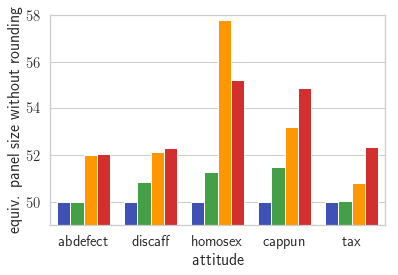

In [43]:
g = sns.barplot(data=d[d["year"] == 2014], x="attitude", y="equiv. panel size without rounding", hue="stratification", saturation=1.)
g.legend_.remove()
g.set_ylim((49, 58))
plt.gcf().subplots_adjust(bottom=0.15)
g.figure.savefig("compare_stratification14_norounding.pdf")

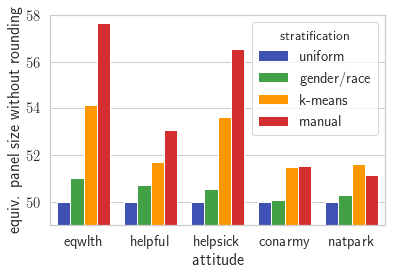

In [44]:
g = sns.barplot(data=d[d["year"] == 2016], x="attitude", y="equiv. panel size without rounding", hue="stratification", saturation=1.)
g.set_ylim((49, 58))
plt.gcf().subplots_adjust(bottom=0.15)
g.figure.savefig("compare_stratification16_norounding.pdf")

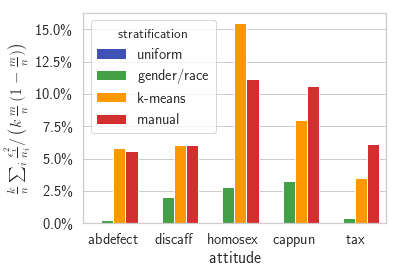

In [45]:
g = sns.barplot(data=d[d["year"] == 2014], x="attitude",
                y="$\\frac{k}{n} \\sum_{i} \\frac{\\epsilon_i^2}{n_i} / \\left(k \\, \\frac{m}{n} \\, (1 - \\frac{m}{n})\\right)$",
                hue="stratification", saturation=1.)
vals = g.get_yticks()
g.set_yticklabels([f"{x:.1%}".replace("%", "\\%") for x in vals])
plt.gcf().subplots_adjust(bottom=0.15, left=0.2)
g.figure.savefig("simple_fraction14.pdf")

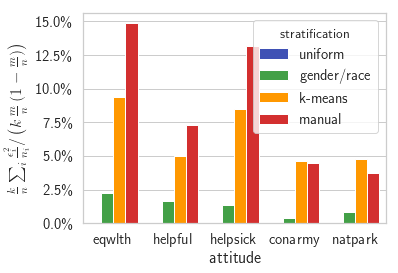

In [46]:
g = sns.barplot(data=d[d["year"] == 2016], x="attitude",
                y="$\\frac{k}{n} \\sum_{i} \\frac{\\epsilon_i^2}{n_i} / \\left(k \\, \\frac{m}{n} \\, (1 - \\frac{m}{n})\\right)$",
                hue="stratification", saturation=1.)
vals = g.get_yticks()
g.set_yticklabels([f"{x:.1%}".replace("%", "\\%") for x in vals])
plt.gcf().subplots_adjust(bottom=0.15, left=0.2)
g.figure.savefig("simple_fraction16.pdf")

In [47]:
for approach in candidates:
    da = d[d["stratification"] == approach]
    avg = (da["equiv. panel size without rounding"] - da["equivalent panel size"]).mean()
    print(approach, avg)

uniform 0.0
gender/race 0.03661053873072504
k-means 1.3198017138635514
manual 0.8335565363729813


In [48]:
roundings = []
for approach in ["k-means", "manual"]:
    for year in years:
        for att, _ in nonrev_atts[year]:
            strat = candidates[approach][year]
            mi, ni = count_mi_ni(datas[year][att + "_bin"], strat["stratum"])
            ell = len(ni)
            rhoi, gi = get_layout(ni, k)
            roundings += [{"stratification": approach, "year": year, "attitude": att,
                           "$\\rho_i \\, (\\rho_i - 1)$": rhoi[i] * (1 - rhoi[i]),
                           "$(m_i/n_i - m_{i+1}/n_{i+1})^2$": (mi[i]/ni[i] - mi[i+1]/ni[i+1])**2}
                          for i in range(ell - 1)]
d3 = pd.DataFrame(roundings)

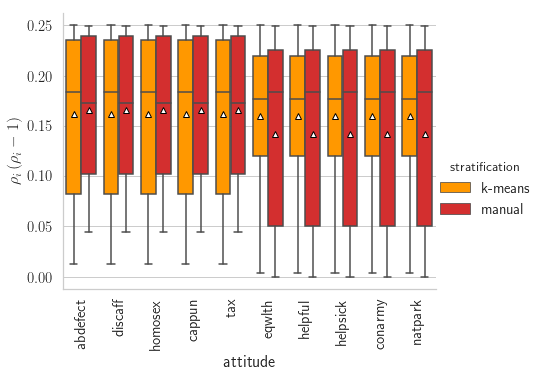

In [49]:
g = sns.catplot(data=d3, x="attitude", y="$\\rho_i \\, (\\rho_i - 1)$",
                hue="stratification", dodge=True, aspect=1.3, kind="box", palette=sns.color_palette()[2:],
                showmeans=True, meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, saturation=1.)
plt.xticks(rotation=90)
g.savefig("alignment.pdf")

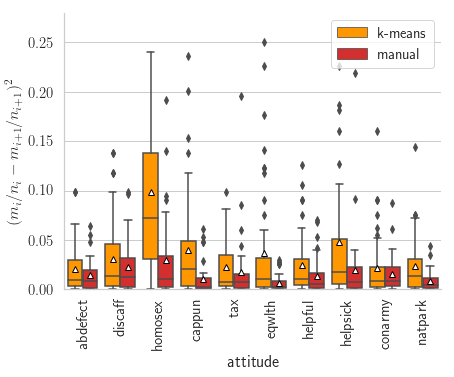

In [50]:
g = sns.catplot(data=d3, x="attitude", y="$(m_i/n_i - m_{i+1}/n_{i+1})^2$",
                hue="stratification", dodge=True, aspect=1.3, kind="box", palette=sns.color_palette()[2:],
                showmeans=True, meanprops={"markerfacecolor": "white", "markeredgecolor": "black"}, legend=False, saturation=1.)
plt.legend(loc="upper right")
g.ax.set_ylim((0, 0.28))
plt.xticks(rotation=90)
g.savefig("adjacency.pdf")

In [51]:
d3[d3["$(m_i/n_i - m_{i+1}/n_{i+1})^2$"] > 0.28]

,$(m_i/n_i - m_{i+1}/n_{i+1})^2$,"$\rho_i \, (\rho_i - 1)$",attitude,stratification,year
116,0.342032,0.062087,homosex,k-means,2014
128,0.551837,0.245806,homosex,k-means,2014
129,0.326531,0.248085,homosex,k-means,2014


In [52]:
def plot_stratification(data, hidden_feature, strata, sort=False):
    lowred = sns.desaturate(red, .85)
    lowgreen = sns.desaturate(green, .85)
    
    n = len(data)
    m = len(data[data[hidden_feature] == 1])
    combination = data.join(strata, how="inner")
    mi, ni = count_mi_ni(combination[hidden_feature], combination["stratum"])
    # top bar (red) from -nx * m / n + mx to nx * (1 - m / n)
    # lower bar (green) from -nx * m / n to -nx * m / n + mx
    # subbar between -nx * m / n + mx and 0 is hatched
    # simulate by four bars:
    # green plain from -nx * m / n to min(-nx * m / n + mx, 0)
    # red hatched from min(-nx * m / n + mx, 0) to 0
    # green hatched from 0 to max(-nx * m / n + mx, 0)
    # red plain from max(-nx * m / n + mx, 0) to x * (1 - m / n)
    
    bots = [- nx * m/n for nx in ni]
    gpupper = [min(-nx * m/n + mx, 0) for mx, nx in zip(mi, ni)]
    rhupper = [0 for _ in ni]
    ghupper = [max(-nx * m/n + mx, 0) for mx, nx in zip(mi, ni)]
    rpupper = [nx * (1 - m/n) for nx in ni]
    mui = [mx / nx for mx, nx in zip(mi, ni)]
    epsi = [mx - m / n * nx for mx, nx in zip(mi, ni)]
    d = pd.DataFrame({"bots": bots, "gp": gpupper, "rh": rhupper, "gh": ghupper, "rp": rpupper, "mui": mui, "stratum": range(len(ni)), "epsi": epsi})
    if sort:
        d = d.sort_values("mui").reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x=d.index, height=d["gp"]-d["bots"], bottom=d["bots"], color=lowgreen)
    ax.bar(x=d.index, height=d["rh"]-d["gp"], bottom=d["gp"], color=lowred, hatch="///")
    ax.bar(x=d.index, height=d["gh"]-d["rh"], bottom=d["rh"], color=lowgreen, hatch="///")
    ax.bar(x=d.index, height=d["rp"]-d["gh"], bottom=d["gh"], color=lowred)
    ax.plot(d.index, d["epsi"], "D", color="black")
    if sort:
        ax.set_xlabel("strata sorted by $m_i/n_i$")
    else:
        ax.set_xlabel("strata in order")
    ax.set_ylabel("$\\epsilon_i$ (black diamonds)")
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    return fig

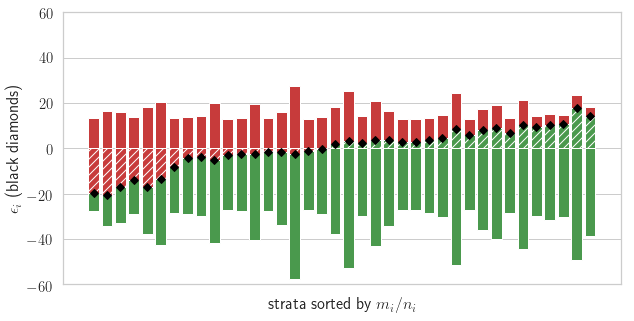

In [53]:
g = plot_stratification(datas[2016], "eqwlth_bin", manuals[2016], True)
g.axes[0].set_ylim((-60, 60))
g.savefig("manuals_eqwlth.pdf")

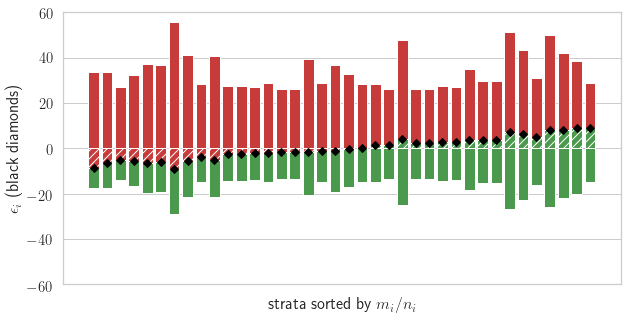

In [54]:
g = plot_stratification(datas[2016], "natpark_bin", manuals[2016], True)
g.axes[0].set_ylim((-60, 60))
g.savefig("manuals_natpark.pdf")

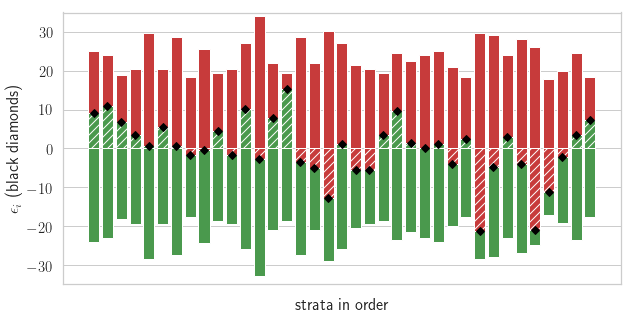

In [55]:
g = plot_stratification(datas[2014], "homosex_bin", manuals[2014], False)
g.axes[0].set_ylim((-35, 35))
g.savefig("manuals_homosex.pdf")

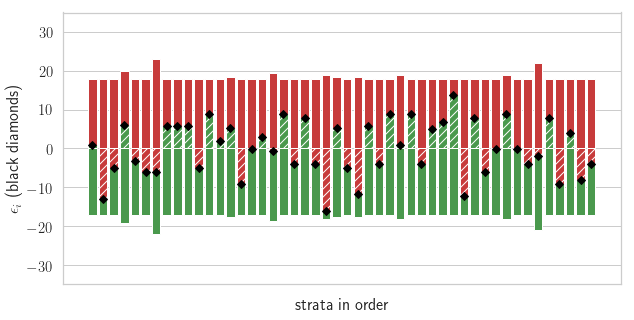

In [56]:
g = plot_stratification(datas[2014], "homosex_bin", kmeans[2014], False)
g.axes[0].set_ylim((-35, 35))
g.savefig("kmeans_homosex.pdf")

In [57]:
simple_fraction(datas[2016], "eqwlth_bin", manuals[2016], k), simple_fraction(datas[2016], "natpark_bin", manuals[2016], k)

(0.14875458868807015, 0.03735610480118369)

In [58]:
m = len(datas[2014][datas[2014]["tax_bin"] == 1])
expvar = compute_variance(datas[2014], "tax_bin", manual_tax, k, "expvar")
varexp = compute_variance(datas[2014], "tax_bin", manual_tax, k, "varexp")
equivalent_k = equivalent_panel_size(expvar + varexp, len(datas[2014]), m, k)
variances.append({"year": 2014, "attitude": "tax", "stratification": "manual known category", "variance": expvar + varexp, "varexp": varexp,
                  "expvar": expvar, "equivalent panel size": equivalent_k})

m = len(datas[2016][datas[2016]["helpsick_bin"] == 1])
expvar = compute_variance(datas[2016], "helpsick_bin", manual_helpsick, k, "expvar")
varexp = compute_variance(datas[2016], "helpsick_bin", manual_helpsick, k, "varexp")
equivalent_k = equivalent_panel_size(expvar + varexp, len(datas[2016]), m, k)
variances.append({"year": 2016, "attitude": "helpsick", "stratification": "manual known category", "variance": expvar + varexp, "varexp": varexp,
                  "expvar": expvar, "equivalent panel size": equivalent_k})

In [59]:
d2 = pd.DataFrame(variances)

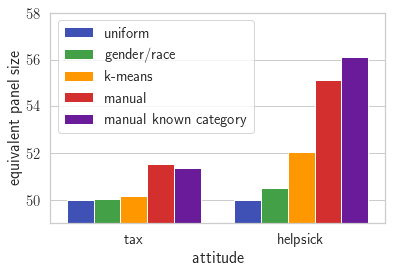

In [60]:
g = sns.barplot(data=d2[d2["attitude"].isin(["tax", "helpsick"])], x="attitude", y="equivalent panel size", hue="stratification", saturation=1.)
g.set_ylim((49, 58))
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc="upper left")
g.figure.savefig("compare_stratification_withrev.pdf")